In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, Flatten
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from indicators.syncind import SyncInd
from indicators.classic import SMA, Alligator, SmoothMA, RSI, MACD, ATR, WMA, EMA, RMA
from indicators.candle import OHLC

In [4]:
import time, datetime
from fyers_apiv3 import fyersModel
client_id = "ZHQ4IJL7TI-100"
with open("access_token", "r") as f:
    access_token = f.read()

fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")

In [5]:
date_today = datetime.datetime.now().strftime("%Y-%m-%d")
date_100_p = (datetime.datetime.now() - datetime.timedelta(days=100)).strftime("%Y-%m-%d")
date_today, date_100_p

('2024-11-21', '2024-08-13')

In [6]:
response = fyers.history(data={"symbol": "NSE:ZEEL-EQ",
                                "resolution": "1",
                                 "date_format": "1",
                                "range_from": date_100_p,
                                "range_to": date_today,
                                "cont_flag": "1"
                                })

len(response['candles']), response

(25935,
 {'candles': [[1723520700, 136.65, 137.3, 136.49, 137.24, 104552],
   [1723520760, 137.24, 137.24, 136.85, 136.95, 59548],
   [1723520820, 136.95, 137.15, 136.86, 137.05, 45886],
   [1723520880, 137.05, 137.05, 136.85, 136.89, 23903],
   [1723520940, 136.8, 136.89, 136.68, 136.77, 29208],
   [1723521000, 136.77, 136.79, 136.25, 136.3, 40240],
   [1723521060, 136.42, 136.62, 136.32, 136.61, 28461],
   [1723521120, 136.61, 136.95, 136.55, 136.95, 47602],
   [1723521180, 136.95, 136.97, 136.82, 136.94, 12776],
   [1723521240, 136.94, 136.94, 136.7, 136.7, 10933],
   [1723521300, 136.76, 136.93, 136.7, 136.92, 10906],
   [1723521360, 136.85, 136.9, 136.57, 136.64, 24140],
   [1723521420, 136.64, 136.8, 136.59, 136.8, 9005],
   [1723521480, 136.67, 136.91, 136.67, 136.91, 6432],
   [1723521540, 136.93, 137, 136.92, 137, 18301],
   [1723521600, 136.99, 137, 136.79, 136.8, 13836],
   [1723521660, 136.8, 136.92, 136.66, 136.67, 51735],
   [1723521720, 136.67, 136.87, 136.67, 136.87, 94

In [7]:
candles = np.array(response['candles'])
type(candles), candles

(numpy.ndarray,
 array([[1.72352070e+09, 1.36650000e+02, 1.37300000e+02, 1.36490000e+02,
         1.37240000e+02, 1.04552000e+05],
        [1.72352076e+09, 1.37240000e+02, 1.37240000e+02, 1.36850000e+02,
         1.36950000e+02, 5.95480000e+04],
        [1.72352082e+09, 1.36950000e+02, 1.37150000e+02, 1.36860000e+02,
         1.37050000e+02, 4.58860000e+04],
        ...,
        [1.73218302e+09, 1.18420000e+02, 1.18450000e+02, 1.18330000e+02,
         1.18350000e+02, 4.36910000e+04],
        [1.73218308e+09, 1.18260000e+02, 1.18330000e+02, 1.18150000e+02,
         1.18150000e+02, 1.52701000e+05],
        [1.73218314e+09, 1.18000000e+02, 1.18000000e+02, 1.17500000e+02,
         1.17990000e+02, 2.65994000e+05]]))

In [8]:
sync = SyncInd( 
                SMA(5),
                SMA(15),
                Alligator()
              )
                
for c in candles:
    sync.append(c)

In [9]:
sync.data()[50]

array([1723523712.0, 136.4199981689453, 136.5, 136.4199981689453,
       136.4600067138672, 3048.0, 136.54, 136.62, 136.9, 136.9, 136.57],
      dtype=object)

In [10]:
X, y = [], []

last_candles_count = 8
next_candles_count = 3

current_data = sync.data()[:, 1:]

for ind in range(50+(last_candles_count), current_data.shape[0]-50-(next_candles_count-1)):

    first_candle = current_data[ind-last_candles_count]
    temp = []
    for i in range(1, last_candles_count):
        temp.append(first_candle - current_data[(ind-last_candles_count)+i])

    X.append(temp)
    temp = []
    for j in range(next_candles_count):
        temp.append((first_candle - current_data[(ind + j)])[1])
    y.append(temp)
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [11]:
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.05, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24533, 7, 10), (24533, 3), (1292, 7, 10), (1292, 3))

In [12]:
model = Sequential()
model.add(Input(shape=X_train.shape[1:]))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(next_candles_count))
# model.add(Reshape(y_train.shape[1:]))
model.compile(optimizer='adam', loss='mse')

In [43]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2523 - val_loss: 0.4019
Epoch 2/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2071 - val_loss: 0.4068
Epoch 3/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2159 - val_loss: 0.4125
Epoch 4/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.3021 - val_loss: 0.4101
Epoch 5/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.2189 - val_loss: 0.3968
Epoch 6/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2089 - val_loss: 0.4028
Epoch 7/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2082 - val_loss: 0.4043
Epoch 8/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2215 - val_loss: 0.3937
Epoch 9/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.3069 - val_loss: 0.4042
Epoch 10/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2329 - val_loss: 0.4029
Epoch 11/100
614/614 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.2197 - val_loss: 0.3921
Epoch 12/100
614/614 ━━━━━━━━━

In [44]:
X.shape, y.shape

(TensorShape([25825, 7, 10]), TensorShape([25825, 3]))

In [45]:
y_pred = model.predict(X_test)
y_pred

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[ 0.08166399,  0.07278117,  0.06688009],
       [ 0.20823309,  0.21037784,  0.19916536],
       [ 0.16013396,  0.15152264,  0.14238653],
       ...,
       [-0.02969449, -0.04256444, -0.04693766],
       [ 0.06119774,  0.04662848,  0.03438579],
       [ 0.01948361,  0.01509789,  0.00598571]], dtype=float32)

In [46]:
for y_p, y_t in zip(y_pred, y_test):
    print("\n", (y_t[0]-y_p[0]), "\t", (y_t[1]-y_p[1]), "\t", (y_t[2]-y_p[2]))


 -0.13165942 	 -0.04278239 	 -0.07688223

 0.031772405 	 0.029627651 	 0.08083342

 -0.13013518 	 -0.12152386 	 -0.0723792

 -0.024957925 	 0.037333548 	 0.12312265

 -0.16809934 	 -0.25653517 	 -0.30114865

 -0.26039648 	 -0.2565662 	 -0.29381034

 0.19964716 	 0.16172212 	 -0.023741573

 -0.17333487 	 -0.16964823 	 -0.13380912

 0.010725275 	 -0.030826315 	 -0.5809908

 -0.012683831 	 0.04202529 	 0.11968746

 0.19153336 	 0.56162506 	 0.54470307

 -0.20344436 	 -0.22617987 	 -0.14289458

 -0.10768459 	 -0.09710819 	 -0.076717064

 -0.050004803 	 0.030085512 	 0.03841751

 -0.038073964 	 -0.18695587 	 -0.1842978

 0.16000062 	 0.12610894 	 0.21487957

 -0.118765615 	 -0.6081935 	 -0.5203472

 -0.07811722 	 0.13391805 	 -0.052120805

 0.44746324 	 0.46020353 	 0.52272475

 0.0105968565 	 0.013965756 	 0.04118234

 -0.10942754 	 -0.086804986 	 -0.07850516

 0.39748254 	 0.46022502 	 0.3227468

 -0.0675562 	 -0.0055259764 	 0.098270595

 -0.1510472 	 -0.1278984 	 -0.098695174

 0.37747

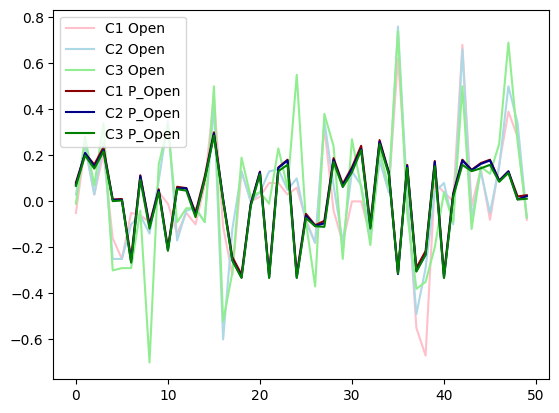

In [47]:
# Example for the first feature (e.g., Close price)
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
plt.plot(y_test[:50, 1], label='C2 Open', color="lightblue")
plt.plot(y_test[:50, 2], label='C3 Open', color="lightgreen")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="darkred")
plt.plot(y_pred[:50, 1], label='C2 P_Open', color="darkblue")
plt.plot(y_pred[:50, 2], label='C3 P_Open', color="green")
plt.legend()
plt.show()

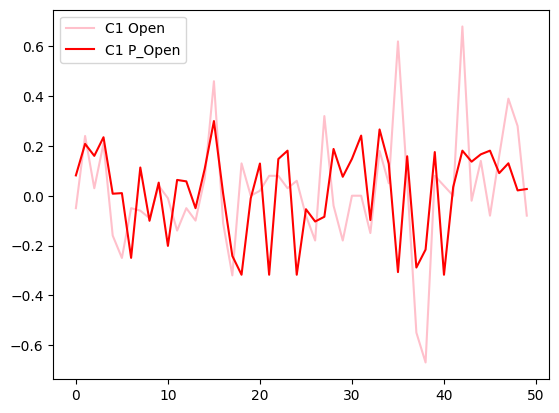

In [48]:
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
# plt.plot(y[0:5, 1], label='C2 Open', color="blue")
# plt.plot(y[0:5, 2], label='C3 Open', color="green")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="red")
# plt.plot(y_pred[0:5, 1], label='C2 P_Open', color="darkblue")
# plt.plot(y_pred[0:5, 2], label='C3 P_Open', color="darkgreen")
plt.legend()
plt.show()

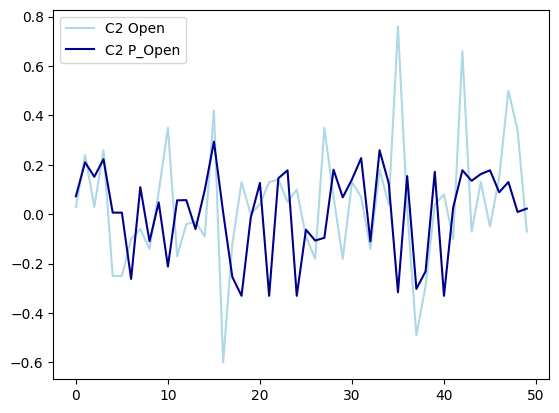

In [49]:
plt.plot(y_test[:50, 1], label='C2 Open', color="lightblue")
# plt.plot(y[0:5, 2], label='C3 Open', color="green")
# plt.plot(y_pred[0:5, 0], label='C1 P_Open', color="darkred")
plt.plot(y_pred[:50, 1], label='C2 P_Open', color="darkblue")
# plt.plot(y_pred[0:5, 2], label='C3 P_Open', color="darkgreen")
plt.legend()
plt.show()

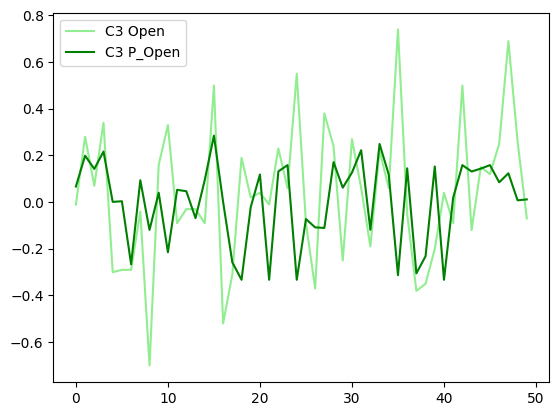

In [50]:
plt.plot(y_test[:50, 2], label='C3 Open', color="lightgreen")
# plt.plot(y_pred[0:5, 0], label='C1 P_Open', color="darkred")
# plt.plot(y_pred[0:5, 1], label='C2 P_Open', color="darkblue")
plt.plot(y_pred[:50, 2], label='C3 P_Open', color="green")
plt.legend()
plt.show()

In [51]:
model.save("21NOV_1.keras")